We will instantiate the ExcitonDriver class as an array of 5 monomers spaced along the x-axis.
Each monomer will have an exciton energy of 1.5 and a transition dipole moment along z with a magnitude of 0.5.

In [1]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np
import math

from matplotlib import animation, rc
from IPython.display import HTML
#from PIL import Image as 


args = {  
'exciton_energy': 1.5,
'number_of_monomers' : 2,
'displacement_between_monomers' : np.array([1, 0, 0]), 
'transition_dipole_moment' : np.array([0, 0, 0.5]) 
}  

sf = wptherml.SpectrumFactory()  
test = sf.spectrum_factory('Frenkel', args)
test.build_exciton_hamiltonian()


We will call the `compute_exciton_wavefunction_site_basis()`, which 
will evaluate the wavefunctions localized along the sites of each monomer as follows:

$$ \phi_n(x) = a \: {\rm exp}\left( -\frac{(x-x_n)^2}{2c^2} \right) $$

where $x_n$ is x-coordinate for the center of mass of exciton on site $n$.

In [2]:
test.compute_exciton_wavefunction_site_basis()

Calling this method also create a grid of $x$ values spanning values between `.x_min` and `.x_max`, which are derived
from the `.number_of_monomers` and `.displacement_between_monomers` attributes.

In [3]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

### parameters for plot
ax.set_xlim((test.x_min, test.x_max))
ax.set_ylim((0, 4))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
plt.show()
#plt.savefig("exciton_plot.png")

We can plot a few of these exciton wavefunctions as follows:

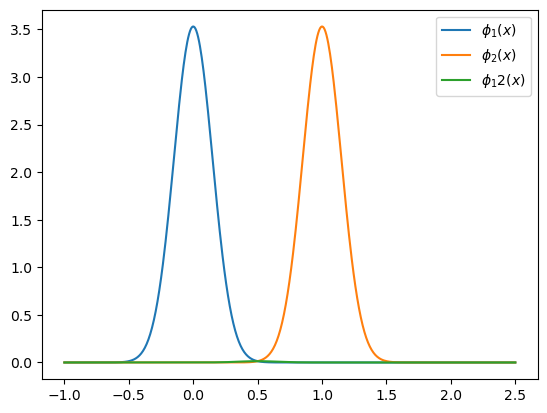

In [4]:
plt.plot(test.x, test.phi[:,0] ** 2, label="$\phi_1(x)$")
plt.plot(test.x, test.phi[:,1] ** 2, label="$\phi_2(x)$")
plt.plot(test.x, test.phi[:,0] * test.phi[:,1], label="$\phi_12(x)$")
#plt.plot(test.x, test.phi[:,3], label="$\phi_4(x)$")
plt.legend()
plt.show()

The following animates the dynamics of a exciton wavefunction given for the chain of monomers that takes 
the form

\begin{equation}\tag{1}
P(x,t) = D_{11} \phi^2_1(x) + D_{12}\phi_1(x) \phi_2(x) + D_{21}\phi_2(x) \phi_1(x)  + D_{22}\phi^2_2(x),  
\end{equation}

where the elements of ${\bf D}$ are updated using `_rk_exciton_density_matrix(dt)`.  

This is equvalent to defining $P(x,t) = \Psi^*(x,t) \Psi(x,t)$ where 

\begin{align}\tag{2}
\Psi(x,t) &= c_1 \phi_1(x) + c_2 \phi_2(x) \\
\Psi^*(x,t) &= c^*_1 \phi_1(x) + c^*_2 \phi_2(x) \\
P(x,t) &= c^*_1 c_1 \phi_1^2(x) + c^*_1 c_2 \phi_1(x) \phi_2(x)  + c^*_2 c_1 \phi_2(x) \phi_1(x) + c^*_2 c_2 \phi_2^2(x).
\end{align}

Note that because $c^*_i c_j = c_j c^*_i = D_{ji}$ and $\phi_i(x) \phi_j(x) = \phi_j(x) \phi_i(x)$,
we can see that the definition of $P(x,t)$ in Eq. (1) is equivalent to $P(x,t)$ in Eq. (2).

In [5]:
N_time = 100
t = np.zeros(N_time)


# animation function. This is called sequentially  
def animate(i):
    t = i / 10
    # _rk_exciton_density_matrix() does not return anything so you don't kneed an "E = " on the l.h.s.
    test._rk_exciton_density_matrix(0.01) #<== run your rk4 method here! use smallish timestep... ~ 0.01

    
    # trace of density matrix should be 1... if this assert statement fails, probably
    # means you need a smaller timestep for the Runge-Kutta integrator
    tr_d = np.trace(test.density_matrix)
    assert np.isclose(tr_d, 1.0)
    
    # initialize p to be an array of complex zeros
    # note the imaginary part should go to zero after summing up all
    # terms below but individual terms will be complex
    p = np.zeros(len(test.phi[:,0]), dtype=complex)
    
    for j in range(test.number_of_monomers):
        for k in range(test.number_of_monomers):
            p[:] += test.density_matrix[j, k] * test.phi[:,j] * test.phi[:,k]


    line.set_data(test.x, p)
    return (line,)
  

anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=N_time, interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim
#anim.save('exciton_1.gif', dpi=500)#, save_all="true", loops=0)

/opt/homebrew/Caskroom/miniforge/base/envs/wptherml/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
